## **<font color='#8d5383'>import library </font>**

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import warnings
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns



# Ignore convergence warnings for a cleaner output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:


# --- Step 1: Load and Preprocess the Article Publications Dataset ---

def load_and_preprocess_articles_data(url='https://vincentarelbundock.github.io/Rdatasets/csv/pscl/bioChemists.csv'):
    """
    Loads and preprocesses the bioChemists (article publications) dataset.
    """
    print("--- Step 1: Loading and Preprocessing Article Publications Data ---")
    df = pd.read_csv(url)

    # Drop the first column which is an unnecessary index
    df = df.drop(df.columns[0], axis=1)

    # Analyze the target variable
    y = df['art'].values
    zero_percentage = (np.sum(y == 0) / len(y)) * 100
    print(f"Percentage of zeros in target variable ('art'): {zero_percentage:.2f}%")
    print("Confirmed: High zero-inflation makes this dataset ideal for ZIP models.\n")

    # Define features and target
    X = df.drop('art', axis=1)

    categorical_features = ['fem', 'mar']
    numerical_features = ['kid5', 'phd', 'ment']

    # Create a preprocessor to handle different feature types
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ],
        remainder='passthrough'
    )

    return X, y, preprocessor

In [3]:


# --- Step 2: Define Models and Loss Functions ---

def zip_loss(y_true, lambda_pred, pi_pred):
    """Negative Log-Likelihood loss for a Zero-Inflated Poisson distribution."""
    epsilon = 1e-8
    zero_mask = (y_true == 0)
    non_zero_mask = ~zero_mask

    # Log-likelihood for zero outcomes
    log_likelihood_zeros = torch.log(pi_pred[zero_mask] + (1 - pi_pred[zero_mask]) * torch.exp(-lambda_pred[zero_mask]) + epsilon)

    # Log-likelihood for non-zero outcomes
    log_likelihood_non_zeros = (torch.log(1 - pi_pred[non_zero_mask] + epsilon)
                                - lambda_pred[non_zero_mask]
                                + y_true[non_zero_mask] * torch.log(lambda_pred[non_zero_mask] + epsilon)
                                - torch.lgamma(y_true[non_zero_mask] + 1))

    return -(torch.sum(log_likelihood_zeros) + torch.sum(log_likelihood_non_zeros)) / y_true.shape[0]

class EarlyStopping:
    """Stops training when a monitored metric has stopped improving."""
    def __init__(self, patience=25, verbose=False, path='checkpoint.pt'):
        self.patience, self.verbose, self.path = patience, verbose, path
        self.counter, self.best_score, self.early_stop, self.val_loss_min = 0, None, False, np.inf

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score, self.counter = score, 0
            self.save_checkpoint(val_loss, model)

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


class ZIPNN(nn.Module):
    def __init__(self, input_dim, h1=16, h2=8, drop=0.5):
        super(ZIPNN, self).__init__()
        self.shared_network = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(),
            nn.Dropout(drop)
        )
        self.lambda_head = nn.Sequential(nn.Linear(h2, 1), nn.Softplus())
        self.pi_head = nn.Sequential(nn.Linear(h2, 1), nn.Sigmoid())
    def forward(self, x):
        hidden = self.shared_network(x)
        return self.lambda_head(hidden), self.pi_head(hidden)

In [4]:


# --- Step 3: Helper Functions ---
def calculate_metrics(y_true, y_pred):
    """Calculates evaluation metrics."""
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }

def plot_all_model_comparisons(y_true, predictions_dict):
    """
    Generates a series of plots to visually compare the performance of all models.
    """
    model_names = list(predictions_dict.keys())

    # 1. Predicted vs. Actual Plots
    print("\nGenerating Predicted vs. Actual plots...")
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    for i, name in enumerate(model_names):
        y_pred = predictions_dict[name]
        ax = axes[i]
        ax.scatter(y_true + np.random.normal(0, 0.1, len(y_true)), y_pred, alpha=0.2)
        ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        ax.set_title(name, fontsize=14)
        ax.set_xlabel("Actual Values", fontsize=12)
        ax.set_ylabel("Predicted Values", fontsize=12)
        ax.grid(True)
    fig.suptitle("Comparison of Predicted vs. Actual Values", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

    # 2. Residuals vs. Predicted Plots
    print("\nGenerating Residuals vs. Predicted plots...")
    fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True)
    axes = axes.flatten()
    for i, name in enumerate(model_names):
        y_pred = predictions_dict[name]
        residuals = y_true - y_pred
        ax = axes[i]
        ax.scatter(y_pred, residuals, alpha=0.3)
        ax.axhline(y=0, color='r', linestyle='--')
        ax.set_title(name, fontsize=14)
        ax.set_xlabel("Predicted Values", fontsize=12)
        ax.set_ylabel("Residuals (Error)", fontsize=12)
        ax.grid(True)
    fig.suptitle("Residual Analysis for Each Model", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

    # 3. Distribution Comparison Plots
    print("\nGenerating Distribution Comparison plots...")
    fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
    axes = axes.flatten()
    for i, name in enumerate(model_names):
        y_pred = predictions_dict[name]
        ax = axes[i]
        sns.histplot(y_true, ax=ax, color="blue", label="Actual Data", stat='density', discrete=True)
        sns.kdeplot(y_pred, ax=ax, color="red", label="Model Prediction", lw=2.5)
        ax.set_title(name, fontsize=14)
        ax.set_xlabel("Number of Articles", fontsize=12)
        ax.set_ylabel("Density", fontsize=12)
        ax.legend()
    fig.suptitle("Comparison of Actual and Predicted Distributions", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()


In [5]:


# --- Step 4: Main Execution Block ---
def main():
    """
    This function handles the training and evaluation of all models.
    """
    X, y, preprocessor = load_and_preprocess_articles_data()

    # Stratified split to preserve the proportion of zeros
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=(y > 0))
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=(y_train > 0))

    # Apply preprocessing
    X_train = preprocessor.fit_transform(X_train)
    X_val = preprocessor.transform(X_val)
    X_test = preprocessor.transform(X_test)

    results, predictions = {}, {}
    print("--- Step 2: Training and Evaluating Models ---")

    # Baseline models
    print("Training baseline models (Poisson & Classical ZIP)...")
    poisson_model = PoissonRegressor(alpha=1.0).fit(X_train, y_train)
    y_pred_poisson = poisson_model.predict(X_test)
    results['Poisson Regression'] = calculate_metrics(y_test, y_pred_poisson)
    predictions['Poisson Regression'] = y_pred_poisson

    zip_model = sm.ZeroInflatedPoisson(y_train, sm.add_constant(X_train)).fit(maxiter=1000, disp=0)
    y_pred_zip = zip_model.predict(sm.add_constant(X_test))
    results['Classical ZIP'] = calculate_metrics(y_test, y_pred_zip)
    predictions['Classical ZIP'] = y_pred_zip
    print("Done.\n")

    # PyTorch Setup
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)), batch_size=128, shuffle=True)
    X_val_t, y_val_t, X_test_t = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32).unsqueeze(1), torch.tensor(X_test, dtype=torch.float32)
    N_EPOCHS = 200


    # ZIP Neural Network
    print("Training Model 4: ZIP Neural Network...")
    zip_nn_model = ZIPNN(input_dim=X_train.shape[1])
    optimizer = torch.optim.AdamW(zip_nn_model.parameters(), lr=0.001, weight_decay=2e-2)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.5)
    early_stopping = EarlyStopping(patience=40, path='zip_nn_checkpoint.pt')
    for epoch in range(N_EPOCHS):
        zip_nn_model.train()
        for x_b, y_b in train_loader:
            l, p = zip_nn_model(x_b)
            loss = zip_loss(y_b, l, p)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        zip_nn_model.eval()
        with torch.no_grad(): val_loss = zip_loss(y_val_t, *zip_nn_model(X_val_t))
        scheduler.step(val_loss)
        early_stopping(val_loss, zip_nn_model)
        if early_stopping.early_stop:
            print(f"ZIP NN training stopped early at epoch {epoch+1}")
            break
    zip_nn_model.load_state_dict(torch.load('zip_nn_checkpoint.pt'))
    with torch.no_grad():
        l, p = zip_nn_model(X_test_t)
        y_pred_zip_nn = ((1 - p) * l).numpy().flatten()
    results['ZIP NN (Ours)'] = calculate_metrics(y_test, y_pred_zip_nn)
    predictions['ZIP NN (Ours)'] = y_pred_zip_nn
    print("Done.\n")

      # Final Results
    print("--- Step 3: Final Model Comparison Results ---")
    results_df = pd.DataFrame(results).T.round(2).sort_values(by='RMSE')
    print(results_df)

    # Return results for use in the visualization function
    return y_test, predictions



In [6]:


# --- NEW: Separate function for visualizations ---
def run_visualizations(y_true, predictions_dict):
    """
    This function plots all comparative charts for visual analysis of model performance.
    """
    print("\n--- Step 4: Visualizing Model Performance ---")
    plot_all_model_comparisons(y_true, predictions_dict)

In [7]:
y_true_results, predictions_results = main()

--- Step 1: Loading and Preprocessing Article Publications Data ---
Percentage of zeros in target variable ('art'): 30.05%
Confirmed: High zero-inflation makes this dataset ideal for ZIP models.

--- Step 2: Training and Evaluating Models ---
Training baseline models (Poisson & Classical ZIP)...
Done.

Training Model 4: ZIP Neural Network...
Done.

--- Step 3: Final Model Comparison Results ---
                     MAE   MSE  RMSE
ZIP NN (Ours)       1.22  2.95  1.72
Poisson Regression  1.30  3.05  1.75
Classical ZIP       1.30  3.28  1.81



--- Step 4: Visualizing Model Performance ---

Generating Predicted vs. Actual plots...


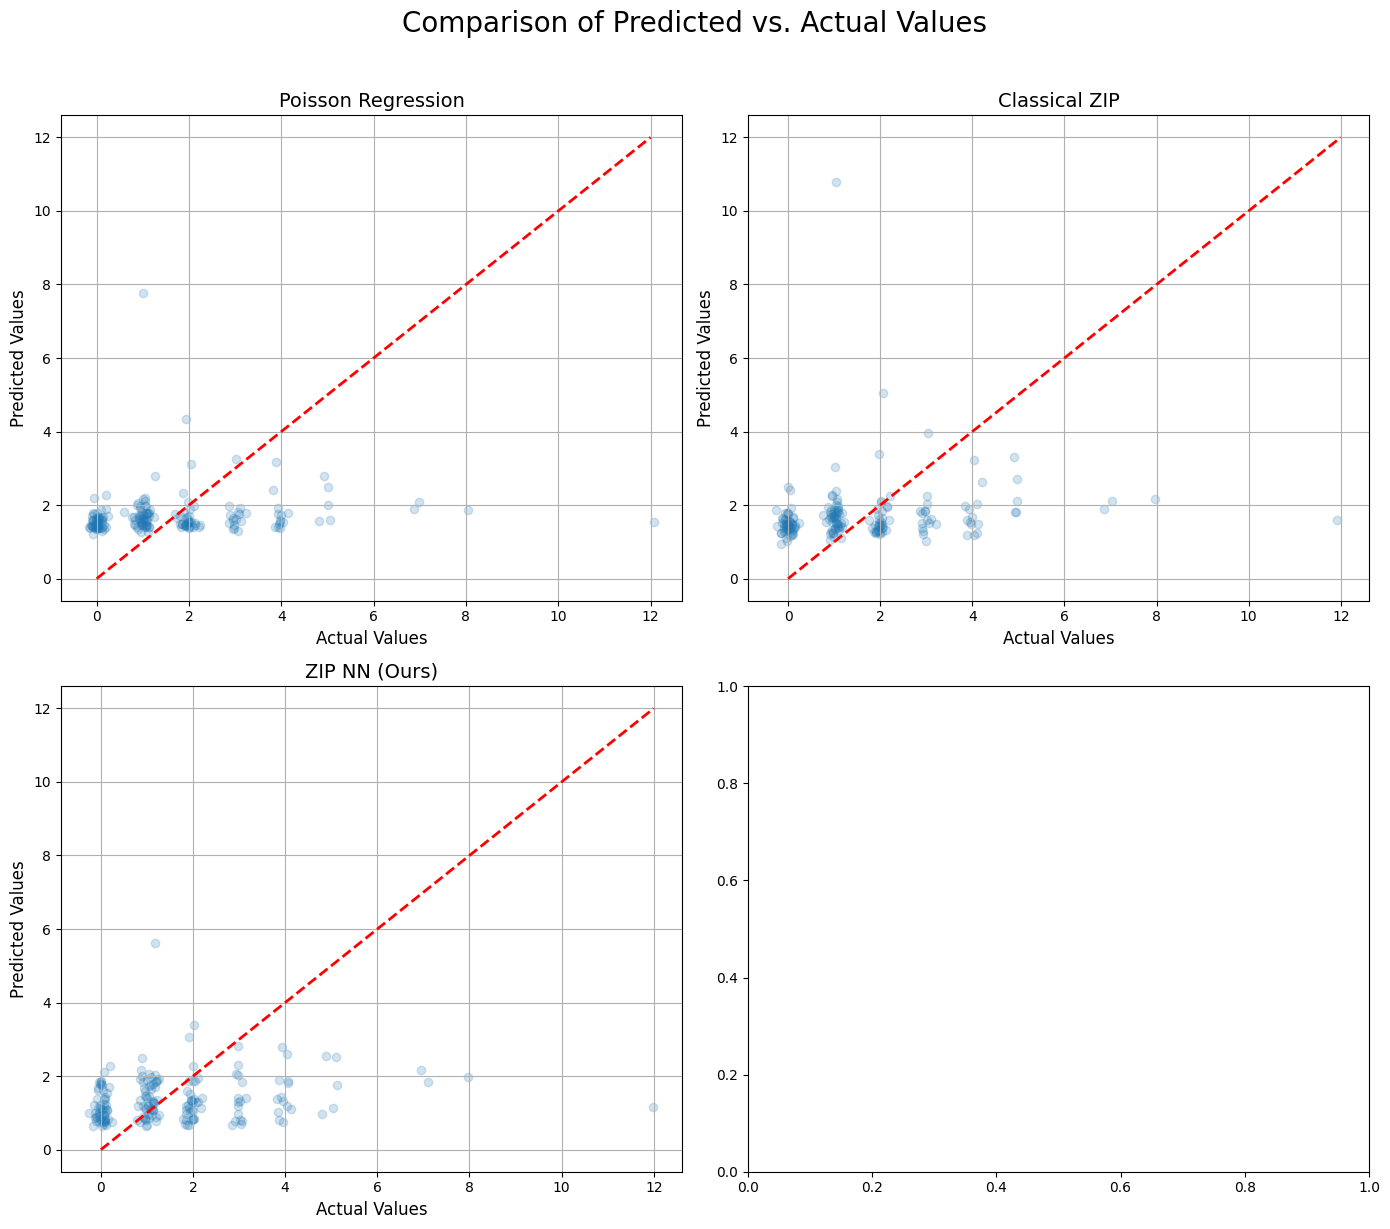


Generating Residuals vs. Predicted plots...


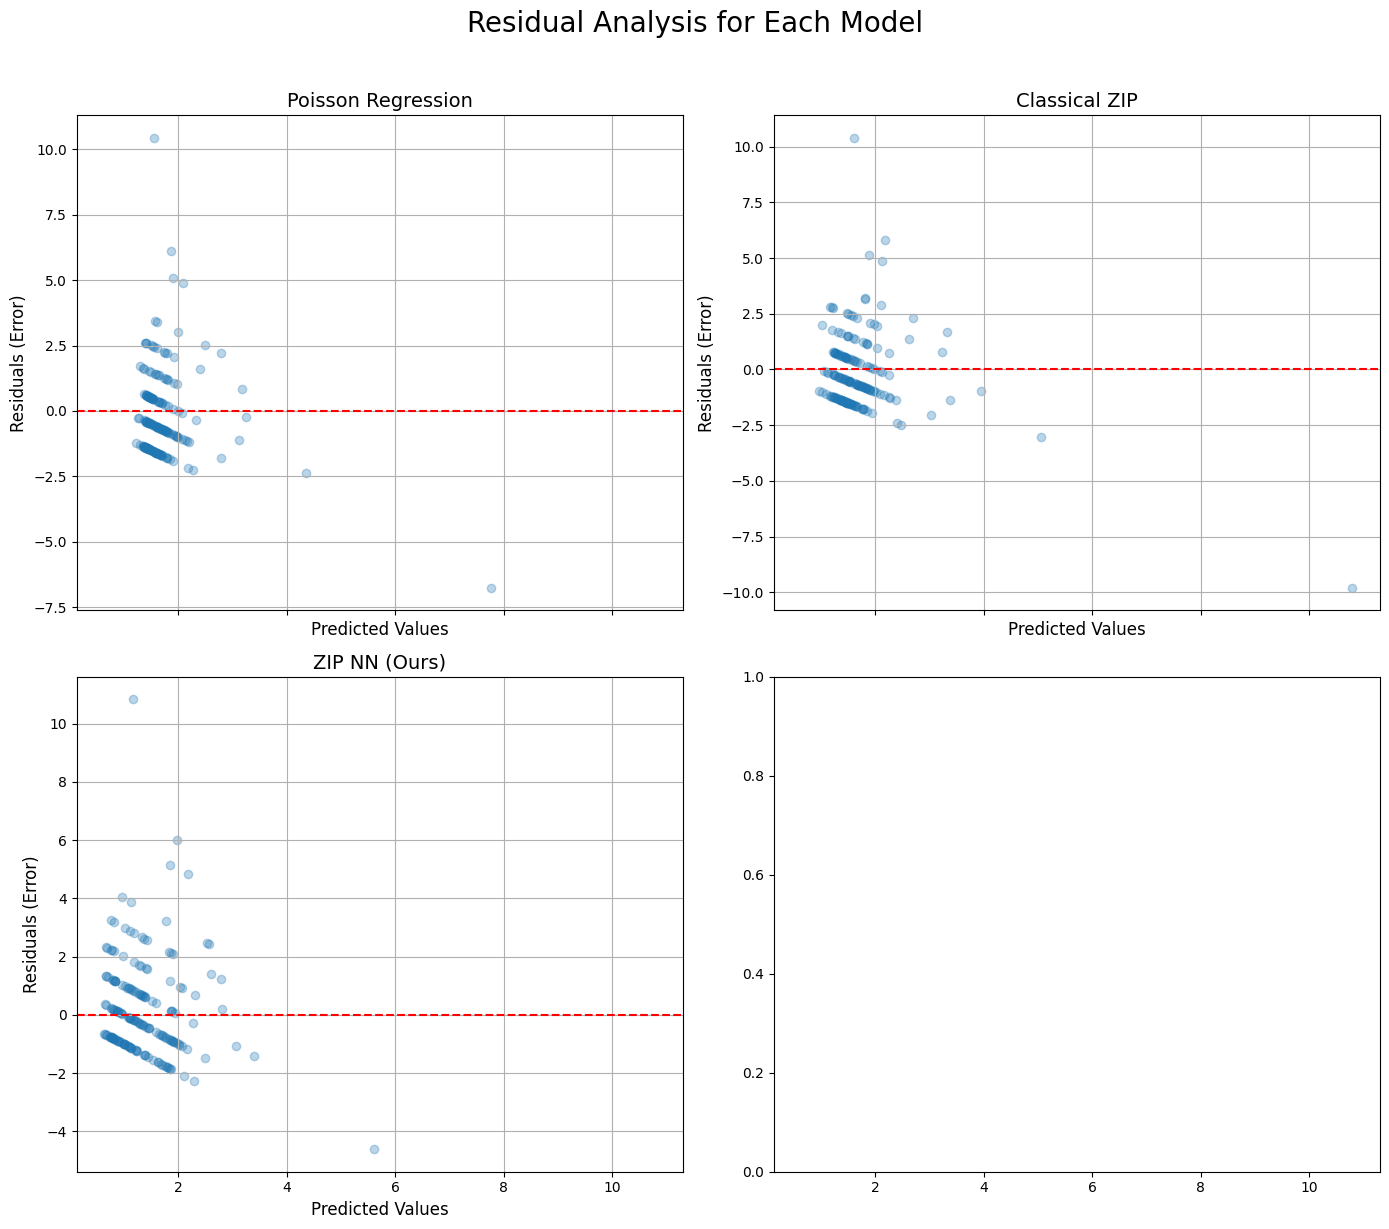


Generating Distribution Comparison plots...


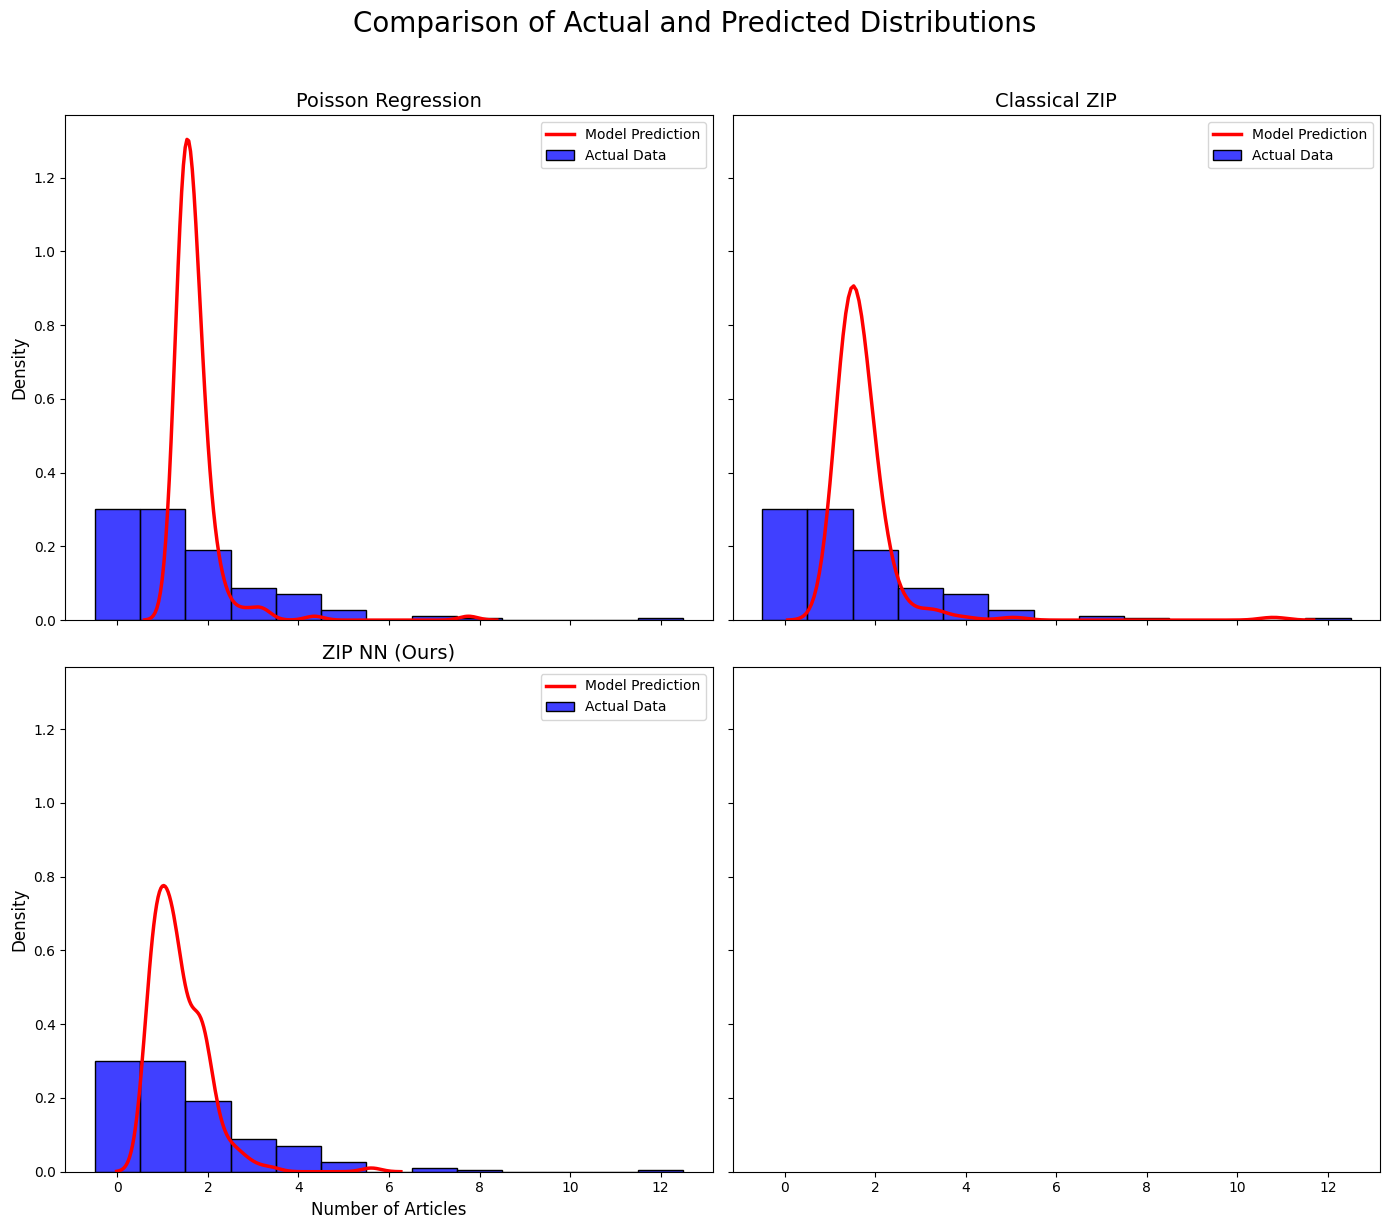

In [8]:
run_visualizations(y_true_results, predictions_results)